# Inicializálás

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/szakdoga/code

/content/drive/MyDrive/szakdoga/code


In [3]:
%cd /content/drive/MyDrive/szakdoga/code/SelectiveForgetting

/content/drive/MyDrive/szakdoga/code/SelectiveForgetting


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/unlearning/SelectiveForgetting/')

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
import numpy as np
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import models
import datasets
from utils import *

<ipython-input-5-d2631281d325>:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
def pdb():
    import pdb
    pdb.set_trace

def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

# Modell betanítása

In [ ]:
%cd /content/drive/MyDrive/szakdoga/code/SelectiveForgetting

/content/drive/MyDrive/szakdoga/code/SelectiveForgetting


CIFAR10-en az eredeti

In [8]:
%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.01 --lossfn ce --num-classes 10
#875,607s

Checkpoint name: cifar10_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in cifar10_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Number of Classes: 10
[0] train metrics:{"loss": 1.4221462241744995, "error": 0.5278599999618531, "accuracy": 0.472140000038147}
Learning Rate : 0.01
[0] dry_run metrics:{"loss": 1.063426960144043, "error": 0.37625999994277953, "accuracy": 0.6237400000572204}
Learning Rate : 0.01
[0] test metrics:{"loss": 1.0852485136032104, "error": 0.3811, "accuracy": 0.6189}
Learning Rate : 0.01
Epoch Time: 51.38 sec
[1] train metrics:{"loss": 0.9125008579635621, "error": 0.32285999996185305, "accuracy": 0.677140000038147}
Learning Rate : 0.01
Epoch Time: 25.58 sec
[2] train metrics:{"loss": 0.6919419876861572, "error": 0.23784, "accuracy": 0.76216}
Learning Rate : 0.01
Epoch Time: 25.15 sec
[3] train metrics:{"loss": 0.558220680809021, "error": 0.186

In [ ]:
%run main.py --dataset cifar10 --model resnet --filters 1.0 --lr 0.01 --lossfn ce --num-classes 10\
--weight-decay 0.001


Checkpoint name: cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1
[Logging in cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Number of Classes: 10
[0] train metrics:{"loss": 1.3135734716796874, "error": 0.4773199999809265, "accuracy": 0.5226800000190734}
Learning Rate : 0.01
[0] dry_run metrics:{"loss": 1.059177386894226, "error": 0.36167999994277955, "accuracy": 0.6383200000572204}
Learning Rate : 0.01
[0] test metrics:{"loss": 1.1119182554244995, "error": 0.3796, "accuracy": 0.6204}
Learning Rate : 0.01
Epoch Time: 85.04 sec
[1] train metrics:{"loss": 0.8103730427742004, "error": 0.27717999996185305, "accuracy": 0.722820000038147}
Learning Rate : 0.01
Epoch Time: 50.28 sec
[2] train metrics:{"loss": 0.6004860434722901, "error": 0.19311999994277954, "accuracy": 0.8068800000572205}
Learning Rate : 0.01
Epoch Time: 50.43 sec
[3] train metrics:{"loss": 0.483660140

Elfeledtetendő adatok megjelölése és fine-tuning

In [ ]:
%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.01\
--resume checkpoints/cifar10_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn\
--weight-decay 0.001 --batch-size 128 --epochs 31 --seed 1 --forget-class 0 --num-to-forget 1000
#29,068s
# cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_001_seed_1_30.pt
#cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0005_seed_1_30.pt

Checkpoint name: cifar10_resnet_0_4_forget_0_num_1000_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1
[Logging in cifar10_resnet_0_4_forget_0_num_1000_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255  9438 13629 47852 41146  8898 38000 37083 15309
 41960 18445  1166 42644 36252 14520 14407 25191 42934 38312 4

In [8]:
%run main.py --dataset cifar10 --model resnet --filters 0.4 --lr 0.01\
--weight-decay 0.001 --batch-size 128 --epochs 31\
--forget-class 0 --num-to-forget 1000 --seed 1
#29,498s

Checkpoint name: cifar10_resnet_0_4_forget_0_num_1000_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1
[Logging in cifar10_resnet_0_4_forget_0_num_1000_lr_0_01_bs_128_ls_ce_wd_0_001_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [ 4030 38518 48266 45556  6312 25460 11479 22410  1463 25318 40806 12420
 46902  3335  9058 32109  4778 28400 17842 24745  1540 15661  4061 42649
 47711 10855 30710 42786 37358  4540 40928 38718 43998 19067 24355 13473
 38011 36183 39080 34417 36606 25514 46586 15827  5988 21865  6719 41858
  3842 30272 39121 37718  1319 16553 18854 43649  5331 47585 22299 28924
 21217  9312 26332 30645 44031  4599 20574 28068 45163 20454  3891 39480
  8655 37199  5623 12668  9983  1340 36491 32592 29092  3076 35599  3053
 12499  8190 10893 13090 19749 36148 30321  6954 41879  4957  2946 29505
 28272 42235 28449 11255  9438 13629 47852 41146  8898 38000 37083 15309
 41960 18445  1166 42644 36252 14520 14407 25191 42934 38312 4

In [ ]:
print(args)

Namespace(augment=False, batch_size=128, dataset='small_cifar5', disable_bn=True, epochs=31, filters=1.0, forget_class=0, l1=False, lossfn='ce', lr=0.01, model='resnet', momentum=0.9, no_cuda=False, num_classes=5, num_to_forget=25, name='small_cifar5_resnet_1_0_forget_0_num_25_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1', resume='checkpoints/cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_25.pt', seed=1, step_size=32, unfreeze_start=None, weight_decay=0.1, device=device(type='cuda'))


# Adatok betöltése

In [ ]:
args = {'augment':False, 
        'batch_size':128, 'dataset':'small_cifar5', 'disable_bn':True, 'epochs':31, 
        'filters':1.0, 'forget_class':0, 'l1':False, 'lossfn':'ce', 'lr':0.01, 'model':'resnet', 
        'momentum':0.9, 'no_cuda':False, 'num_classes':5, 'num_to_forget':25, 
        'name':'small_cifar5_resnet_1_0_forget_0_num_25_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1', 
        'resume':'checkpoints/cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_25.pt', 
        'seed':1, 'step_size':32, 'unfreeze_start':None, 'weight_decay':0.1}

arch = args['model'] 
filters=args['filters']
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args['dataset']
class_to_forget = args['forget_class']
init_checkpoint = f"checkpoints/{args['name']}_init.pt"
num_classes=args['num_classes']
num_to_forget = args['num_to_forget']

train_loader, valid_loader, test_loader = datasets.get_loaders(args['dataset'], class_to_replace=args['forget_class'], 
                                                               num_indexes_to_replace=args['num_to_forget'], 
                                                               batch_size=args['batch_size'], seed=args['seed'], augment=args['augment'])

num_total = len(train_loader.dataset)
num_to_retain = num_total - num_to_forget
seed = args['seed']
unfreeze_start = None

learningrate=f"lr_{str(args['lr']).replace('.','_')}"
batch_size=f"_bs_{str(args['batch_size'])}"
lossfn=f"_ls_{args['lossfn']}"
wd=f"_wd_{str(args['weight_decay']).replace('.','_')}"
seed_name=f"_seed_{args['seed']}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

100%|██████████| 170498071/170498071 [00:03<00:00, 46727301.35it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified
Replacing indexes [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45]


In [ ]:
log_dict={}
training_epochs=25
log_dict['epoch']=training_epochs

In [ ]:
# m: ami minden képen tanítva van
# m0: ami nem lát bizonyos számú adatot a 0. osztályból
# kérdés: ami nem tanult azon a néhányon, mennyire tudja megtanulni a többit?

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

use_cuda = not args['no_cuda'] and torch.cuda.is_available()
args['device'] = torch.device("cuda" if use_cuda else "cpu")
model = models.get_model(args['model'], num_classes=num_classes, filters_percentage=args['filters']).to(args['device'])

import copy
model0 = copy.deepcopy(model)

model.load_state_dict(torch.load(m_name)) # MODEL WITHOUT FORGETTING: model
model0.load_state_dict(torch.load(m0_name)) # MODEL WITH FORGETTING CLASS 0: model0

model.cuda()
model0.cuda()

for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

In [ ]:
parameter_count(copy.deepcopy(model))

Total Number of Parameters: 11172613


# Modell infók

In [ ]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,928
         _ResBlock-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
        _ResBlock-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14          [-1, 128,

In [ ]:
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): _ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): _ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer2): Sequential(
    (0): _ResBlock(
     

In [ ]:
from models import ResNet18

resnet = ResNet18()
print(resnet)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): _ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): _ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer2): Sequential(
    (0): _ResBlock(
     

# Paraméterek távolsága

In [ ]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [ ]:
log_dict['dist_Original_and_Removed_classes']=distance(model,model0)

Distance: 5.302754585617718
Normalized Distance: 0.07110728090176212


In [ ]:
distance(model,model)

Distance: 0.0
Normalized Distance: 0.0


0.0

# w(D) távolsága az inicializálástól

In [ ]:
def dist_init(resume,seed=1):
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args['device'])
    model_init.load_state_dict(torch.load(resume))
    return model_init

In [ ]:
model_init = dist_init(init_checkpoint,args['seed'])
for p in model_init.parameters():
    p.data0 = p.data.clone() # distance függvényhez - az ezt használja

In [ ]:
log_dict['dist_Original_Original_init']=distance(model_init,model)

Distance: 4.006891938772135
Normalized Distance: 0.0537842702978911


# Data loaders

In [ ]:
# ugyanezek a sorok a mainben is benne wannak - wtf
train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=args['batch_size'], seed=seed, augment=False, shuffle=True)
# Ebben van megjelölve, melyik dataset legyen elfelejtve
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, augment=False, shuffle=True)

def replace_loader_dataset(dataset, batch_size=args['batch_size'], seed=1, shuffle=True):
    manual_seed(seed)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)

# FORGET DATASET
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0 # data to forget is marked negative
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(forget_dataset, seed=seed, shuffle=True)

#RETAIN DATASET
retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(retain_dataset, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45]


In [ ]:
np.unique(marked_loader.dataset.targets)
print(marked_loader.dataset.targets[0])
for i in range(-1, 5):
  print(i, len(marked_loader.dataset.targets[marked_loader.dataset.targets == i]))

0
-1 25
0 75
1 100
2 100
3 100
4 100


# Modellek

In [ ]:
# model_original: a teljes cifar10-en tanított
model_original_name = 'checkpoints/cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_30.pt' 

use_cuda = not args['no_cuda'] and torch.cuda.is_available()
args['device'] = torch.device("cuda" if use_cuda else "cpu")
model_original = models.get_model(args['model'], num_classes=10, filters_percentage=args['filters']).to(args['device'])

model_original.load_state_dict(torch.load(model_original_name)) 

model_original.cuda()

for p in model_original.parameters():
    p.data0 = p.data.clone()

In [ ]:
# model_finetuned: retain adatokon tanítva
%run main.py --dataset cifar10 --model resnet --filters 1.0 --lr 0.01\
--resume checkpoints/cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn\
--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 1 --retain 

# Sample images from the dataset

In [ ]:
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def imshow(imgs, save=False, cl=0):
  fig, ax = plt.subplots(1, len(imgs))

  npimgs = []
  for img in imgs:
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    npimgs.append(npimg)

  for i in range(len(imgs)):
    ax[i].imshow(np.transpose(npimgs[i], (1, 2, 0))) 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  fig.show()

  if save:
    fig.savefig(f'dataset_samples{cl}.png')

def image(num, save=False):
  transform = transforms.Compose( [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
      (0.5, 0.5, 0.5))])

  trainset = tv.datasets.CIFAR10(root='/content/drive/MyDrive/unlearning/SelectiveForgetting/', train=True,
    download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset,
    batch_size=100, shuffle=False, num_workers=1)

  # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
  #   'frog', 'horse', 'ship', 'truck')

  # get first 100 training images
  dataiter = iter(trainloader)
  imgs, lbls = next(dataiter)

  indices = []
  for j in range(100):
      if lbls[j] == 0:  # 0 is plane
        indices.append(j)
  images = [tv.utils.make_grid(imgs[i]) for i in indices[0:num]]
  imshow(images, save)

Files already downloaded and verified


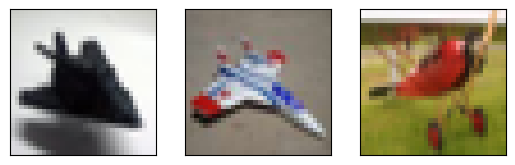

In [ ]:
image(3, True)

# Fisher

In [ ]:
def hessian(dataset, model):
  # kiszámolja a gradienseket és eltárolja őket
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args['device']), orig_target.to(args['device'])
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data # helyes predikciókra nézve
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2) 
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [ ]:
modelf = copy.deepcopy(model) # a sima modell, amin elfeledtetünk majd
modelf0 = copy.deepcopy(model0) # a modell, ami nem lát bizonyos számú adatot a 0. osztályból

In [ ]:
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

In [ ]:
for p in itertools.chain(modelf.parameters(), modelf0.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [ ]:
# covariance of the noise (cikkből)
def get_mean_var(p, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3) # max 1000-es nagyságrend
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var # alfa: mekkora varianciát engedünk meg
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10 # lineáris és batch norm rétegek esetében felskálázzuk a varianciát 10-zel
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [ ]:
# Fisher update

alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    w, var = get_mean_var(p, alpha=alpha)
    p.data = w + var.sqrt() * torch.empty_like(p.data0).normal_()

for i, p in enumerate(modelf0.parameters()):
    w, var = get_mean_var(p, alpha=alpha)
    p.data = w + var.sqrt() * torch.empty_like(p.data0).normal_()

# Kiértékelés

### Segédfüggvények

In [ ]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)

            loss = loss_fn(output, target) + l2_penalty(model,model_init,args['weight_decay']) # a losshoz hozzáadja az l2 távot is
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            # won't use this
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    return metrics.avg

In [ ]:
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', ignore_index=None, quiet=True)

## Súlyokban maradt információ

In [ ]:
baseline = copy.deepcopy(model)
modelf = copy.deepcopy(model) # a sima modell, amin elfeledtetünk majd
modelf0 = copy.deepcopy(model0) # a modell, ami nem lát bizonyos számú adatot a 0. osztályból
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)
hessian(retain_loader.dataset, baseline)

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

In [ ]:
for p in itertools.chain(modelf.parameters(), modelf0.parameters(), baseline.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [ ]:
lambda_list = [5e-7, 5e-5, 5e-3, 5e-1, 1, 1.5] 
results = [] 

for lam in lambda_list:
  alpha_list = [1e-8,1e-7,1e-6,1e-5]
  test_error_list = []
  information_list = []

  runs = 3
  for s in range(runs):
      torch.manual_seed(s)
      test_error_list.append([])
      information_list.append([])
      for alpha in alpha_list:        
          for i, p in enumerate(modelf.parameters()):
              mu, var = get_mean_var(p, alpha=alpha)
              p.data = mu + lam * var.sqrt() * torch.empty_like(p.data0).normal_()

          for i, p in enumerate(modelf0.parameters()):
              mu, var = get_mean_var(p, alpha=alpha)
              p.data = mu + lam * var.sqrt() * torch.empty_like(p.data0).normal_()

          metrics = test(modelf, test_loader_full)

          total_kl = 0
          for (k, p), (k0, p0) in zip(modelf.named_parameters(), modelf0.named_parameters()):
            # összehasonlítja a scrubolt meg a nem scrubolt modelleket, és veszi a kl-jüket
              mu0, var0 = get_mean_var(p, alpha=alpha)
              mu1, var1 = get_mean_var(p0, alpha=alpha)
              kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
              total_kl += kl
              
          test_error_list[s].append(metrics['error'])
          information_list[s].append(total_kl)

  alpha_list = np.ndarray.flatten(np.array([alpha_list for i in range(runs)]))
  test_error_list = np.ndarray.flatten(np.array(test_error_list))
  information_list = np.ndarray.flatten(np.array(information_list))

  info_dict = {}
  info_dict['alpha'] = alpha_list
  info_dict['error'] = [i*100 for i in test_error_list]
  info_dict['info'] = information_list
  df = pd.DataFrame(info_dict)    
  results.append(df)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Plot

In [ ]:
import matplotlib.pyplot as plt
def plot_info(ax,df,information_list,title):
        sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
        ax.set(xscale="log")
        ax.set_xlabel('Maradék információ',size=16)
        ax.set_ylabel('Hiba a teszthalmazon (%)',size=16)
        ax.set_title(title,size=16)
        ax.tick_params(axis="y", labelsize=16)
        ax.tick_params(axis="x", labelsize=16)

<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
<ipython-input-66-241ea7ab18ce>:3: FutureWarning: 

The `ci` parameter

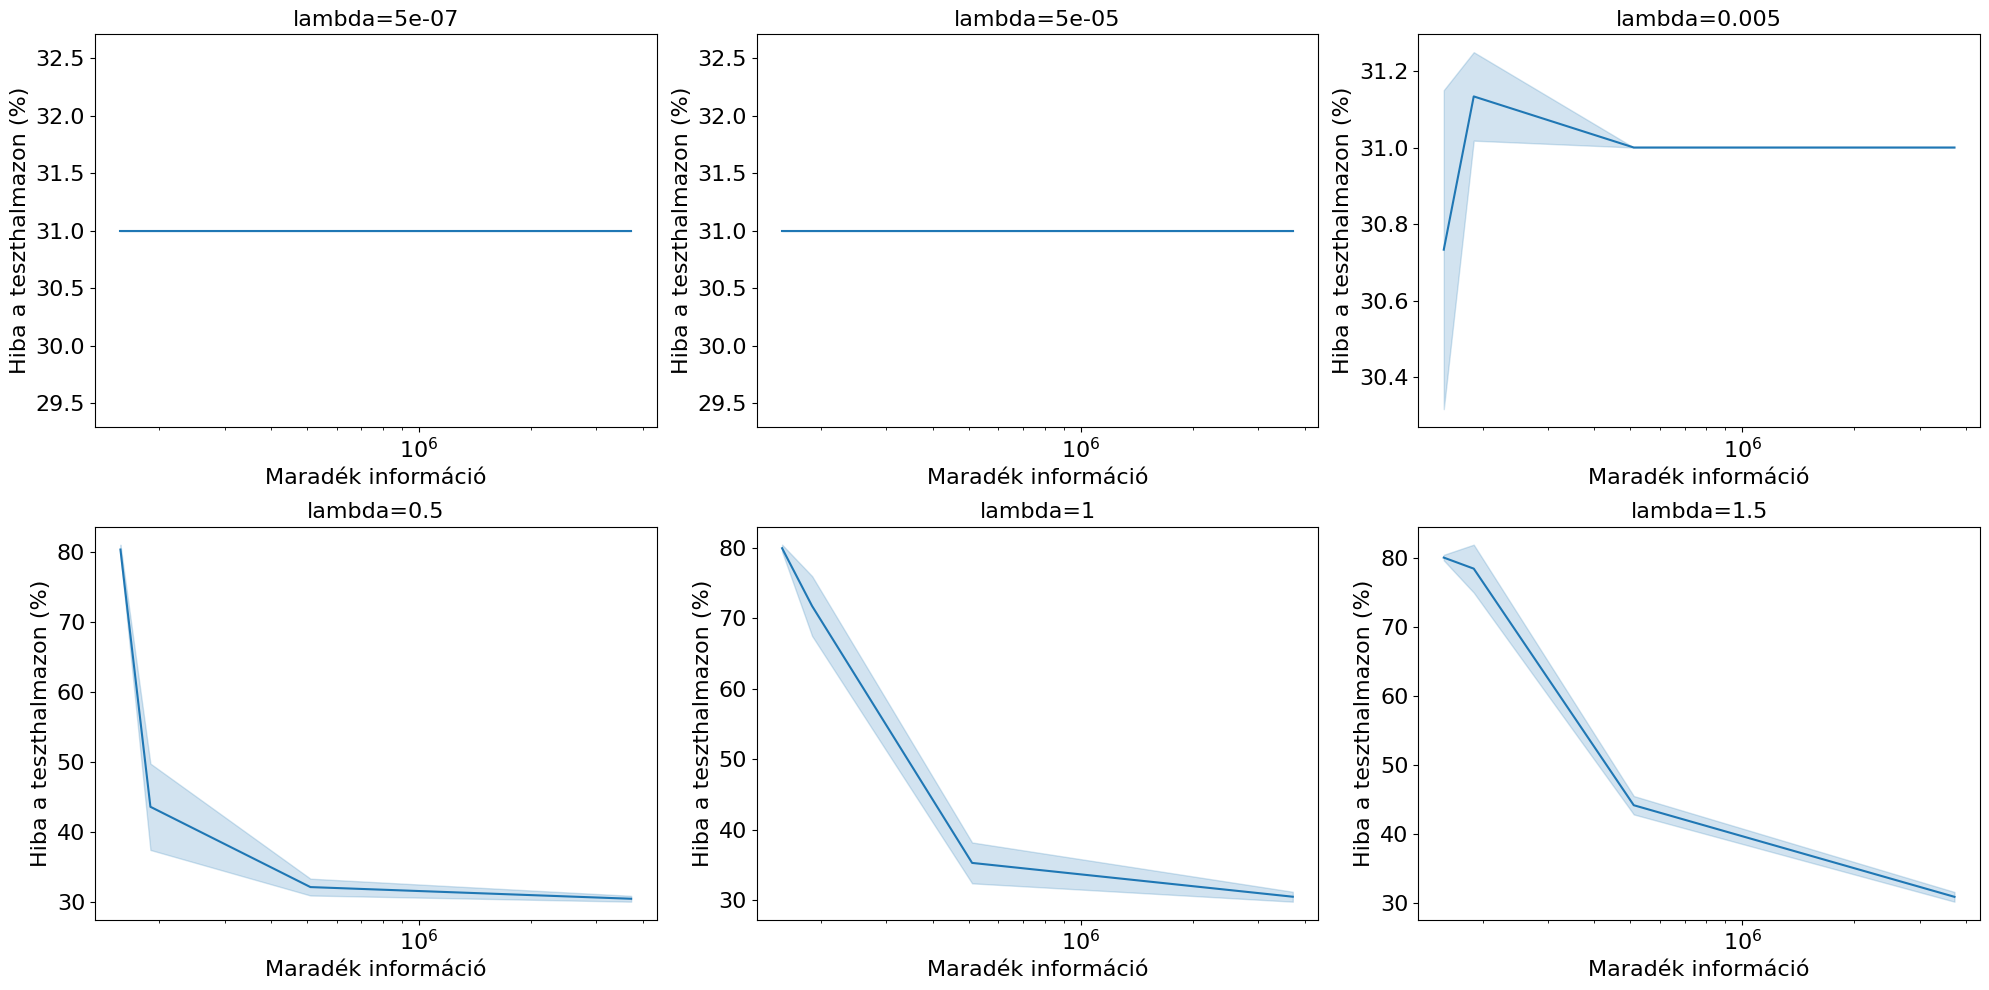

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(5.5,4))
fig, ax = plt.subplots(2,3,figsize=(20, 10))
plot_info(ax[0,0],results[0],None,f'lambda={lambda_list[0]}') 
plot_info(ax[0,1],results[1],None,f'lambda={lambda_list[1]}')
plot_info(ax[0,2],results[2],None,f'lambda={lambda_list[2]}')
plot_info(ax[1,0],results[3],None,f'lambda={lambda_list[3]}')
plot_info(ax[1,1],results[4],None,f'lambda={lambda_list[4]}')
plot_info(ax[1,2],results[5],None,f'lambda={lambda_list[5]}')
fig.tight_layout()
#fig.suptitle('Információ a súlyokban különböző lambdákra')

#fig.savefig('/content/drive/MyDrive/szakdoga/information.png', bbox_inches='tight')

# Hatékonyság

# Hatásosság

# Konzisztencia

In [ ]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        current_dist = (p.data-p0.data).pow(2).sum().item()
        current_norm = p.data.pow(2).sum().item()
        distance += current_dist
        normalization += current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [ ]:
distance(model, model0)

Distance: 5.302754585617718
Normalized Distance: 0.07110728090176212


0.07110728090176212

In [ ]:
distance(model, modelf)

Distance: 103.9678174976278
Normalized Distance: 1.3941563170956672


1.3941563170956672

In [ ]:
distance(model0, modelf0)

Distance: 104.92701170639886
Normalized Distance: 1.4069014624021368


1.4069014624021368

In [ ]:
distance(modelf, modelf0)

Distance: 147.79744265315708
Normalized Distance: 1.155478867906545


1.155478867906545

# Tanúsíthatóság: adattartalmazásra következtető támadás

In [ ]:
from sklearn.svm import SVC

def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):
    # batchenkénti propabilityk
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)
    prob = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    clf = SVC(C=3,gamma='auto',kernel='rbf') #classifier
    #clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X
    return results.mean()
    
def plot_entropy_dist(model, ax, title):
    train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=args['batch_size'], seed=args['seed'], shuffle=False, augment=False)
    indexes = np.flatnonzero(np.array(train_loader_full.dataset.targets) == class_to_forget)
    replaced = np.random.RandomState(0).choice(indexes, size=100 if num_to_forget==100 else len(indexes), replace=False)
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(train_loader_full, test_loader_full, model, replaced)
    sns.distplot(np.log(X_r[Y_r==1]).reshape(-1), kde=False, norm_hist=True, rug=False, label='retain', ax=ax)
    sns.distplot(np.log(X_r[Y_r==0]).reshape(-1), kde=False, norm_hist=True, rug=False, label='test', ax=ax)
    sns.distplot(np.log(X_f).reshape(-1), kde=False, norm_hist=True, rug=False, label='forget', ax=ax)
    ax.legend(prop={'size': 14})
    ax.tick_params(labelsize=12)
    ax.set_title(title,size=18)
    ax.set_xlabel('Log of Entropy',size=14)
    ax.set_ylim(0,0.4)
    ax.set_xlim(-35,2)

def membership_attack(retain_loader,forget_loader,test_loader,model):
    prob = get_membership_attack_prob(retain_loader,forget_loader,test_loader,model)
    print("Attack prob: ", prob)
    return prob

In [ ]:
attack_dict={}

attack_dict['Original']=membership_attack(retain_loader,forget_loader,test_loader_full,model)
attack_dict['Retrain']=membership_attack(retain_loader,forget_loader,test_loader_full,model0)
attack_dict['Fisher']=membership_attack(retain_loader,forget_loader,test_loader_full,modelf)
attack_dict['Fisher0']=membership_attack(retain_loader,forget_loader,test_loader_full,modelf0)

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Attack prob:  0.0


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Attack prob:  0.0


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Attack prob:  0.0


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Attack prob:  0.16
